<a href="https://colab.research.google.com/github/e-ayeni/Regression_in_Insurance/blob/master/Insurance_Claims_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive #mounting my google drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train = pd.read_csv("gdrive/My Drive/Medium Projects/Insurance Claims Competition/train_data.csv")
test = pd.read_csv("gdrive/My Drive/Medium Projects/Insurance Claims Competition/test_data.csv")

In [4]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [5]:
#brief describtion of the dataset

train.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [6]:
#checking for null values in the dataset and decide on how to treat them

train.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [7]:
test.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [8]:
test.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  4
Settlement              0
Building Dimension     13
Building_Type           0
Date_of_Occupancy     728
NumberOfWindows         0
Geo_Code               13
dtype: int64

**<h1>Data Preparation and Analysis<h1>**

**<h3> Treating Null Values<h3>**
    

   <h6>1. Garden = Fill Null with the majority between V & O<h6>
   <h6>2. Building Dimension = Fill with average if it is located in rural or urban area<h6>
   <h6>3. Date_of_Occupancy = Fill with majority year if it is located in rural or urban area<h6>
   <h6>4. Geo_Code = Fill with majority if it is located in rural or urban area<h6>




<h4>1. Garden<h4>

In [9]:
#fill null values for garden. "O" which means no garden is the majority

train["Garden"].value_counts()

O    3602
V    3551
Name: Garden, dtype: int64

In [10]:
train["Garden"].fillna("O", inplace=True)
test["Garden"].fillna("O", inplace=True)

<h4>2. Building Dimension<h4>

In [11]:
settlement = train[["Building Dimension", "Settlement"]]

In [12]:
settlement.head()

,Building Dimension,Settlement
0,290.0,U
1,490.0,R
2,595.0,U
3,2840.0,U
4,680.0,R


In [13]:
#check which settlement type has majority of the null values
#rural has just 1 while urban has 105
#all null values will be filled with the average of rural building dimensions

settlement[settlement["Settlement"]=="U"]["Building Dimension"].isnull().sum()

105

In [14]:
#average size for buildings in urban areas

urban_  = settlement[settlement["Settlement"]=="U"]["Building Dimension"].mean()
urban_

1575.211611030479

In [15]:
#filling null values for building dimensions

train["Building Dimension"].fillna(urban_, inplace=True)
test["Building Dimension"].fillna(urban_, inplace=True)

In [16]:
#quick check

train["Building Dimension"].isnull().sum()

0

In [17]:
train.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  0
Settlement              0
Building Dimension      0
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

<h4>3. Date_of_Occupancy<h4>

In [18]:
#check which settlement type has majority of null values
#urban has majority with 507 while rural has just 1
#null values will be filled with the highest occuring date of occupancy from buildings in urban settlement

train[train["Settlement"]=="U"]["Date_of_Occupancy"].isnull().sum()

507

In [19]:
#highest occuring date of occupancy is 1960

date = train[train["Settlement"]=="U"]["Date_of_Occupancy"].value_counts().head(1)
date

1960.0    1468
Name: Date_of_Occupancy, dtype: int64

In [20]:
#filling null values for date_of_Occupancy

train["Date_of_Occupancy"].fillna(1960, inplace=True)
test["Date_of_Occupancy"].fillna(1960, inplace=True)

In [21]:
#quick check

train.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  0
Settlement              0
Building Dimension      0
Building_Type           0
Date_of_Occupancy       0
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

<h4>4. Geo_Code<h4>

In [22]:
#only buildings in urban areas have null values
#this column would be dropped. I do not think it would impact our model

train[train["Settlement"]=="U"]["Geo_Code"].value_counts()

6088     66
21231    63
33063    58
13206    57
6083     56
         ..
40328     1
93015     1
59482     1
56078     1
13007     1
Name: Geo_Code, Length: 832, dtype: int64

***Cleaning of Columns***

In [23]:
train.drop("Geo_Code",axis=1, inplace=True)
test.drop("Geo_Code",axis=1, inplace=True)

<h5>5. NumberOfWindows<h5>

In [24]:
#the "." here will be treated as null values. And since an overwhelming majority is null, this column will be dropped

train["NumberOfWindows"].value_counts()

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [25]:
train.drop("NumberOfWindows", axis=1, inplace=True)
test.drop("NumberOfWindows", axis=1, inplace=True)

<h5>6. Date_Of_Occupancy<h5>
    
    

*Changing the date of occupancy from a float to integer*

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7160 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7160 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   7160 non-null   float64
 11  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 671.4+ KB


In [27]:
#a function that splits the column into two by "." and then picking the first index

def split_(x):
    x=str(x).split(".")[0]
    return int(x)

In [28]:
#test of the function

split_(1970.0)

1970

In [29]:
#applying the function

train["Date_of_Occupancy"] = train["Date_of_Occupancy"].apply(split_)
test["Date_of_Occupancy"] = test["Date_of_Occupancy"].apply(split_)

In [30]:
#quick check

train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800,0


In [31]:
def split_id(q):
    q=str(q).split("H")[1]
    return int(q)

In [32]:
#This function splits Insured period in 2 groups; 
# Over 0.5 will be 1 year policy duration 
# Less than 0.5 will be no policy duration


#def insured(x):

 # if x < 0.5:
  #  return 0
  #else:
   # return 1

In [33]:
#applying the function

#train["Insured_Period"] = train["Insured_Period"].apply(insured)
#test["Insured_Period"] = test["Insured_Period"].apply(insured)

In [34]:
train["Insured_Period"].value_counts()

1.000000    5325
0.997268     547
0.000000     165
0.747945      60
0.495890      49
            ... 
0.680328       1
0.819672       1
0.792350       1
0.378082       1
0.803279       1
Name: Insured_Period, Length: 401, dtype: int64

In [35]:
train.isnull().sum()

Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
Claim                 0
dtype: int64

*Customer Id*

In [36]:
split_id("H14663")

14663

In [37]:
#applying the function to customer id

train["Customer Id"] = train["Customer Id"].apply(split_id)
test["Customer Id"] = test["Customer Id"].apply(split_id)

In [38]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
0,14663,2013,1.0,0,N,V,V,U,290.0,1,1960,0
1,2037,2015,1.0,0,V,N,O,R,490.0,1,1850,0
2,3802,2014,1.0,0,N,V,V,U,595.0,1,1960,0
3,3834,2013,1.0,0,V,V,V,U,2840.0,1,1960,0
4,5053,2014,1.0,0,V,N,O,R,680.0,1,1800,0


**<h3>Exploratory Data Analyis (EDA)<h3>**

<h6>How many clients have had claims?<h6>

Text(0.5, 1.0, 'No of Claims')

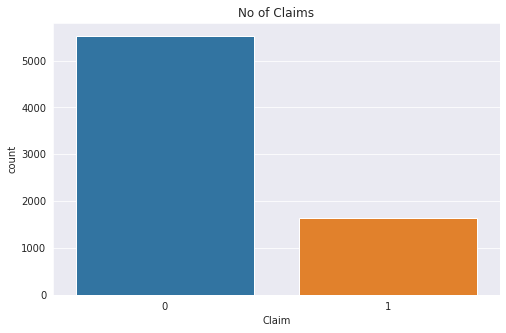

In [39]:
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
sns.countplot(x="Claim", data=train)

plt.title("No of Claims")

<h6>Distribution of Building Types?<h6>

Text(0.5, 1.0, 'Building Type')

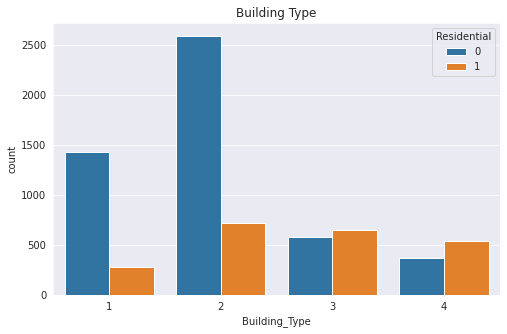

In [40]:
plt.figure(figsize=(8,5))

sns.set_style("darkgrid")
sns.countplot(x="Building_Type",hue="Residential",data=train)

plt.title("Building Type")

More (Residential) buildings in Urban areas?

Text(0.5, 1.0, 'Distribution of Buildings')

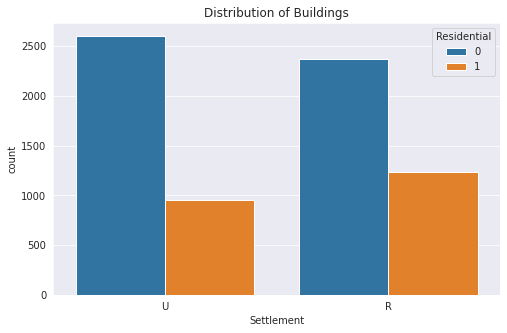

In [41]:
plt.figure(figsize=(8,5))

sns.countplot(x="Settlement",hue="Residential",data=train)

plt.title("Distribution of Buildings")

*Distribution of Customer by year of occupancy*

In [42]:
year = train.groupby("Date_of_Occupancy")["Customer Id"].count().to_frame().reset_index()

In [43]:
year.head()

,Date_of_Occupancy,Customer Id
0,1545,1
1,1550,1
2,1600,5
3,1613,1
4,1700,10


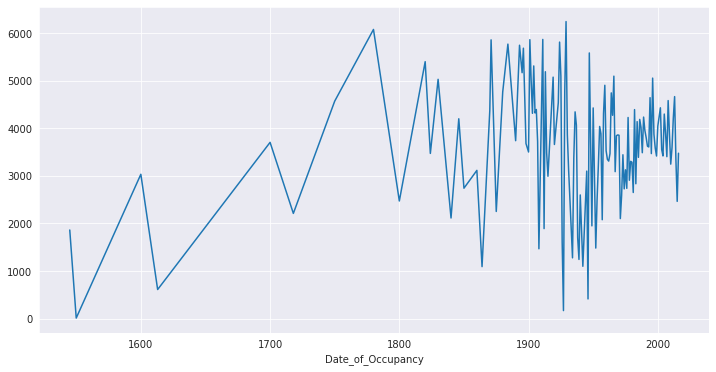

In [44]:
plt.figure(figsize=(12,6))

sns.lineplot(x="Date_of_Occupancy", y=train.index, data=train, err_style=None)

In [50]:
len(train["Insured_Period"].value_counts())

401

In [46]:
wow=year.drop("Customer Id", axis=1)

Year of Policy Observation

In [153]:
observaton = train["YearOfObservation"].value_counts().to_frame().reset_index()

Text(0, 0.5, 'No of Policy')

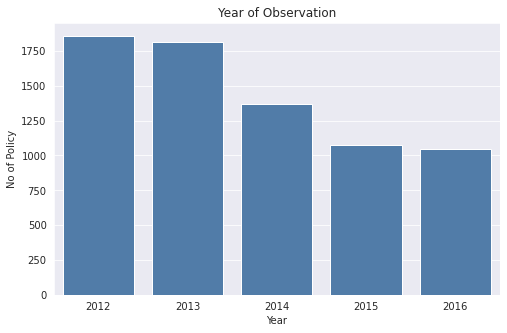

In [154]:
plt.figure(figsize=(8,5))

fig = sns.barplot(x="index",y="YearOfObservation",data=observaton,color="#437CB6")

plt.title("Year of Observation")

fig.set_xlabel("Year")
fig.set_ylabel("No of Policy")

*Building Dimensions*

In [97]:
train.head

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
0,14663,2013,1.0,0,N,V,V,U,290.0,1,1960,0
1,2037,2015,1.0,0,V,N,O,R,490.0,1,1850,0
2,3802,2014,1.0,0,N,V,V,U,595.0,1,1960,0
3,3834,2013,1.0,0,V,V,V,U,2840.0,1,1960,0
4,5053,2014,1.0,0,V,N,O,R,680.0,1,1800,0


In [169]:
#creating a new variable to plot building dimensions

residential=train[train["Residential"]==1]["Building Dimension"].to_frame()
non_residential=train[train["Residential"]==0]["Building Dimension"].to_frame()
residential.head()

,Building Dimension
23,2300.0
33,1000.0
44,487.0
47,650.0
48,650.0


In [170]:
#plt.figure(figsize=(8,5))

#ax = sns.distplot(residential["Building Dimension"], kde=False, hist_kws={"range":[0,20000]})
#ax.set_xlim(0,20000)
#plt.title("Residential Building Dimension")

In [171]:
##plt.figure(figsize=(8,5))

##ax = sns.distplot(non_residential["Building Dimension"], kde=False, hist_kws={"range":[0,20000]})
#ax.set_xlim(0,20000)
#plt.title("Non-Residential Building Dimension")

Text(0.5, 0.98, 'Distribution of Building Dimension')

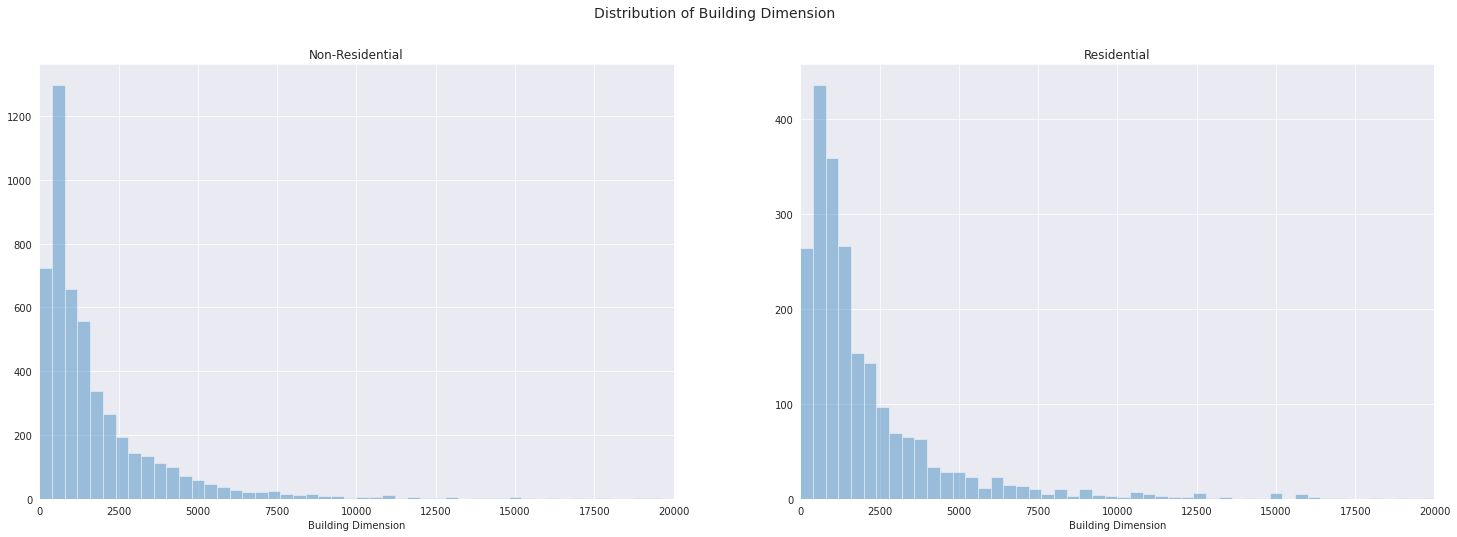

In [177]:
##f,  ((ax1, ax2)) = plt.subplots(nrows=1,ncols=2, figsize=(8,5))
#f.tight_layout()
#f.subplots_adjust(wspace=0.2, hspace=0.5)
f, axes = plt.subplots(1,2, figsize=(25,8))



ax=sns.distplot(non_residential["Building Dimension"], kde=False, hist_kws={"range":[0,20000]}, ax=axes[0])
ax1=sns.distplot(residential["Building Dimension"], kde=False, hist_kws={"range":[0,20000]}, ax=axes[1])

ax.set_xlim(0,20000)
ax1.set_xlim(0,20000)

ax.title.set_text("Non-Residential")
ax1.title.set_text("Residential")
plt.suptitle("Distribution of Building Dimension", fontsize=14)


In [173]:
policy=train[["YearOfObservation","Insured_Period"]]
policy.head()

,YearOfObservation,Insured_Period
0,2013,1.0
1,2015,1.0
2,2014,1.0
3,2013,1.0
4,2014,1.0


In [125]:
policy2=train["Insured_Period"].value_counts().to_frame().reset_index()
policy2.head()

,index,Insured_Period
0,1.000000,5325
1,0.997268,547
2,0.000000,165
3,0.747945,60
4,0.495890,49


In [155]:
#def pol(x):

    
  #if x <25:
   # return "Others"
 # elif x>=25:
  #  return x


*Date of Occupancy*

Text(0.5, 1.0, 'Date of Occupancy')

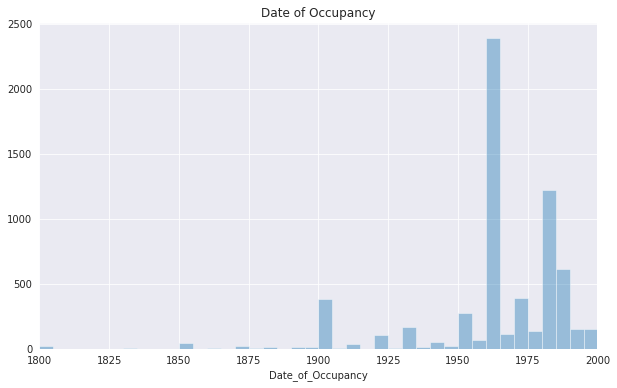

In [167]:
plt.figure(figsize=(10,6))

ax=sns.distplot(train["Date_of_Occupancy"],kde=False,hist_kws={"range":[1800,2000]}, bins=40)

ax.set_xlim(1800,2000)

plt.title("Date of Occupancy")

**Features of those who claimed**

In [125]:
claim = train[train["Claim"]==1]
claim.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
8,19355,2014,1.0,0,V,N,O,R,2735.0,1,2013,1
15,13053,2012,1.0,0,V,N,O,R,3326.0,1,2007,1
16,14330,2014,1.0,0,N,V,V,U,3990.0,1,1988,1
23,4421,2012,1.0,1,V,N,O,R,2300.0,1,1970,1
26,15579,2014,1.0,0,V,N,O,R,5439.0,1,1976,1


Text(0.5, 1.0, 'Fenced Buildings')

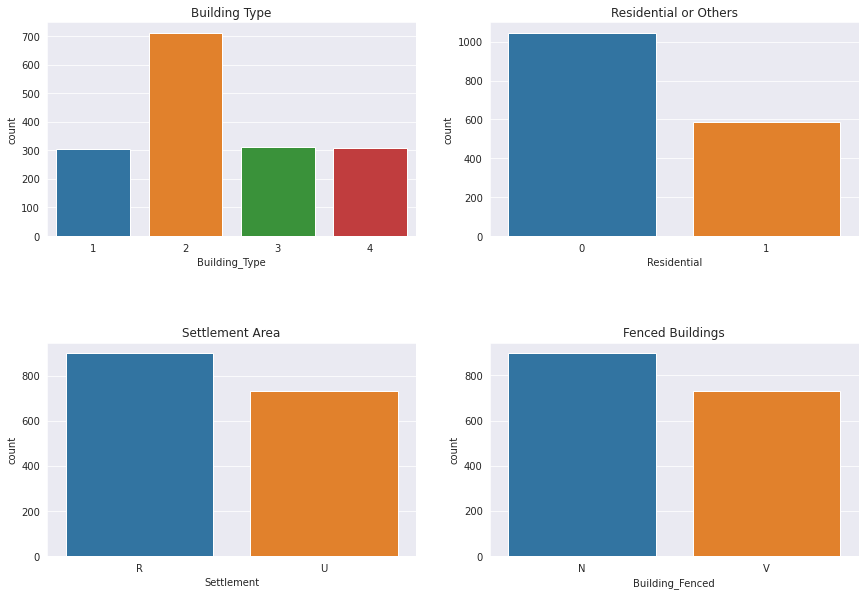

In [126]:
f,  ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
f.tight_layout()
f.subplots_adjust(wspace=0.2, hspace=0.5)





sns.countplot(x="Building_Type",ax=ax1, data=claim)
sns.countplot(x="Residential",ax=ax2, data=claim)
sns.countplot(x="Settlement",ax=ax3, data=claim)
sns.countplot(x="Building_Fenced",ax=ax4, data=claim)

ax1.set_title("Building Type")
ax2.set_title("Residential or Others")
ax3.set_title("Settlement Area")
ax4.set_title("Fenced Buildings")



In [ ]:
year_claim=claim.groupby("Date_of_Occupancy")["Claim"].count().to_frame().reset_index()
year_claim.head()

In [ ]:
plt.figure(figsize=(12,6))

sns.distplot(year_claim["Date_of_Occupancy"])

plt.title("Year of Occupancy")

In [ ]:
period = claim.groupby("Insured_Period")["Claim"].sum().to_frame().reset_index()
period.head()

In [ ]:
train.head()

In [ ]:
plt.figure(figsize=(12,6))

train["Insured_Period"].value_counts()

In [ ]:
f,  ((ax1, ax2)) = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
f.tight_layout()
f.subplots_adjust(wspace=0.2, hspace=0.5)





sns.countplot(x="Garden",ax=ax1, data=claim)
sns.countplot(x="Building_Painted",ax=ax2, data=claim)

**Features of those yet to make a claim**

In [122]:
no_claim = train[train["Claim"]==0]
no_claim.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
0,14663,2013,1.0,0,N,V,V,U,290.0,1,1960,0
1,2037,2015,1.0,0,V,N,O,R,490.0,1,1850,0
2,3802,2014,1.0,0,N,V,V,U,595.0,1,1960,0
3,3834,2013,1.0,0,V,V,V,U,2840.0,1,1960,0
4,5053,2014,1.0,0,V,N,O,R,680.0,1,1800,0


Text(0.5, 1.0, 'Fenced Buildings')

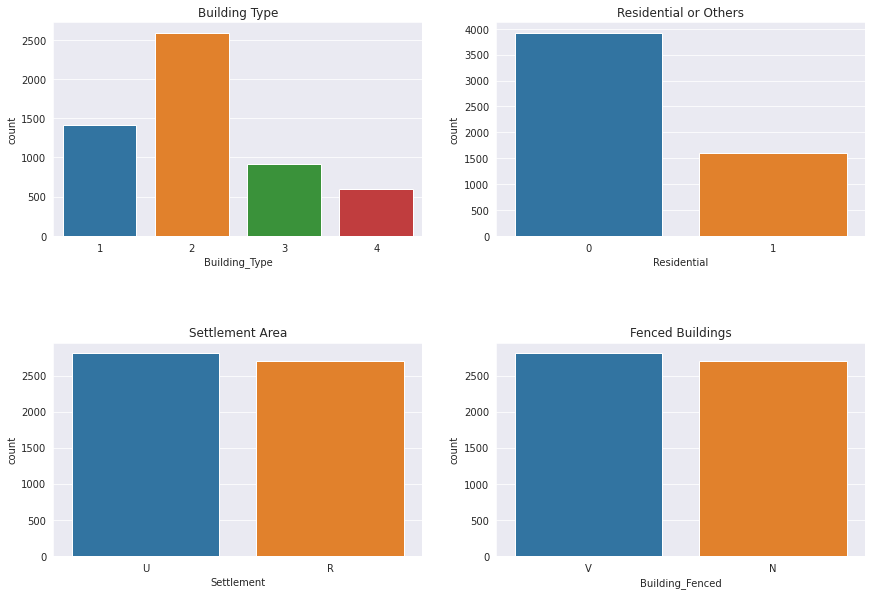

In [123]:
f,  ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
f.tight_layout()
f.subplots_adjust(wspace=0.2, hspace=0.5)





sns.countplot(x="Building_Type",ax=ax1, data=no_claim)
sns.countplot(x="Residential",ax=ax2, data=no_claim)
sns.countplot(x="Settlement",ax=ax3, data=no_claim)
sns.countplot(x="Building_Fenced",ax=ax4, data=no_claim)

ax1.set_title("Building Type")
ax2.set_title("Residential or Others")
ax3.set_title("Settlement Area")
ax4.set_title("Fenced Buildings")

In [ ]:
train.head()

**<h1>Modelling<h1>**

In [178]:
#importing necessary libraries

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix

In [179]:
label_encoder = preprocessing.LabelEncoder()

In [180]:
#tranforming columns to the data type that the training data can understand
#all data should be integers or floats and not strings

train["Building_Painted"] =label_encoder.fit_transform(train["Building_Painted"])
train["Building_Fenced"] =label_encoder.fit_transform(train["Building_Fenced"])
train["Garden"] =label_encoder.fit_transform(train["Garden"])
train["Settlement"]=label_encoder.fit_transform(train["Settlement"])

In [181]:
#tranforming columns to the data type that the test data can understand
#all data should be integers or floats and not strings

#test["Building_Painted"] =label_encoder.fit_transform(test["Building_Painted"])
#test["Building_Fenced"] =label_encoder.fit_transform(test["Building_Fenced"])
#test["Garden"] =label_encoder.fit_transform(test["Garden"])
#test["Settlement"]=label_encoder.fit_transform(test["Settlement"])

In [182]:
#calling our model

reg = linear_model.LinearRegression()

In [183]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
0,14663,2013,1.0,0,0,1,1,1,290.0,1,1960,0
1,2037,2015,1.0,0,1,0,0,0,490.0,1,1850,0
2,3802,2014,1.0,0,0,1,1,1,595.0,1,1960,0
3,3834,2013,1.0,0,1,1,1,1,2840.0,1,1960,0
4,5053,2014,1.0,0,1,0,0,0,680.0,1,1800,0


In [184]:
x = train.drop(["Claim","Customer Id"], axis=1)
y = train["Claim"]

In [185]:
#splitting our training data into 2

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.30, random_state=42)

In [186]:
par = LogisticRegression()

In [187]:
#training our model

par.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [188]:
#testing the model

pred = par.predict(x_test)

In [189]:
#checking the accuracy of the model

accuracy_score(pred,y_test)

0.7793296089385475

In [190]:
#checking accuracy of the model

confusion_matrix(pred, y_test)

array([[1615,  433],
       [  41,   59]])